In [30]:
!pip install yfinance requests pandas matplotlib scikit-learn gym tensorflow


In [31]:
#import the libraries
import numpy as np
import pandas as pd
import yfinance as yf
import requests
import gym
from gym import spaces
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import deque


In [32]:
#loading the stock healthcare data
# Get hospitalization data
hc_url = 'https://api.covidtracking.com/v1/us/daily.json'
hc = pd.DataFrame(requests.get(hc_url).json())
hc['date'] = pd.to_datetime(hc['date'], format='%Y%m%d')
hc = hc[['date', 'hospitalizedCurrently']].sort_values('date').set_index('date')
hc = hc.rename(columns={'hospitalizedCurrently': 'hosp_curr'}).ffill()

# Get stock price
stock = yf.Ticker('AAPL')
df_stock = stock.history(period='5y')[['Close']]
# Remove timezone information from df_stock index
df_stock.index = df_stock.index.tz_convert(None)
df = df_stock.join(hc, how='left').ffill()
display(df)
df.reset_index(inplace=True)

,Close,hosp_curr
Date,,
2020-07-08 04:00:00,92.679489,NaN
2020-07-09 04:00:00,93.078049,NaN
2020-07-10 04:00:00,93.240868,NaN
2020-07-13 04:00:00,92.810722,NaN
2020-07-14 04:00:00,94.346596,NaN
...,...,...
2025-06-30 04:00:00,205.169998,NaN
2025-07-01 04:00:00,207.820007,NaN
2025-07-02 04:00:00,212.440002,NaN


In [33]:
#defining custom environment
class StockHealthEnv(gym.Env):
    def __init__(self, df):
        super(StockHealthEnv, self).__init__()
        self.df = df
        self.current_step = 0
        self.balance = 1000
        self.shares_held = 0
        self.net_worth = self.balance
        self.max_steps = len(df) - 1

        self.action_space = spaces.Discrete(3)  # 0 = Hold, 1 = Buy, 2 = Sell
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(3,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        self.balance = 1000
        self.shares_held = 0
        self.net_worth = self.balance
        return self._get_obs()

    def _get_obs(self):
        row = self.df.iloc[self.current_step]
        return np.array([row['Close'], row['hosp_curr'], self.shares_held], dtype=np.float32)

    def step(self, action):
        row = self.df.iloc[self.current_step]
        current_price = row['Close']

        if action == 1:  # Buy
            if self.balance > current_price:
                self.shares_held += 1
                self.balance -= current_price

        elif action == 2:  # Sell
            if self.shares_held > 0:
                self.shares_held -= 1
                self.balance += current_price

        self.current_step += 1
        done = self.current_step >= self.max_steps
        self.net_worth = self.balance + self.shares_held * current_price
        reward = self.net_worth - 1000  # Reward is net profit

        return self._get_obs(), reward, done, {}


In [34]:
#Define deep Q-Learning Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.memory = deque(maxlen=1000)
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.95
        self.epsilon = 1.0  # exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.model = self._build_model()

    def _build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(24, input_dim=self.state_size, activation='relu'),
            tf.keras.layers.Dense(24, activation='relu'),
            tf.keras.layers.Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(0.001))
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state[np.newaxis])
        return np.argmax(q_values[0])

    def remember(self, s, a, r, s_next, done):
        self.memory.append((s, a, r, s_next, done))

    def replay(self, batch_size=32):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for s, a, r, s_next, done in minibatch:
            target = r
            if not done:
                target = r + self.gamma * np.amax(self.model.predict(s_next[np.newaxis])[0])
            target_f = self.model.predict(s[np.newaxis])
            target_f[0][a] = target
            self.model.fit(s[np.newaxis], target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [35]:
#Training the Agent
env = StockHealthEnv(df)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

episodes = 10
for e in range(episodes):
    state = env.reset()
    total_reward = 0
    for time in range(env.max_steps):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            print(f"Episode {e+1}/{episodes} — Final Net Worth: ${env.net_worth:.2f}")
            break
    agent.replay()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode 1/10 — Final Net Worth: $1224.88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━

In [36]:
state = env.reset()
for _ in range(env.max_steps):
    action = agent.act(state)
    state, _, done, _ = env.step(action)
    if done:
        break

print("\n✅ Final Investment Decision by Agent:")
print("Net Worth:", env.net_worth)
print("Shares Held:", env.shares_held)
print("Cash Remaining:", env.balance)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━

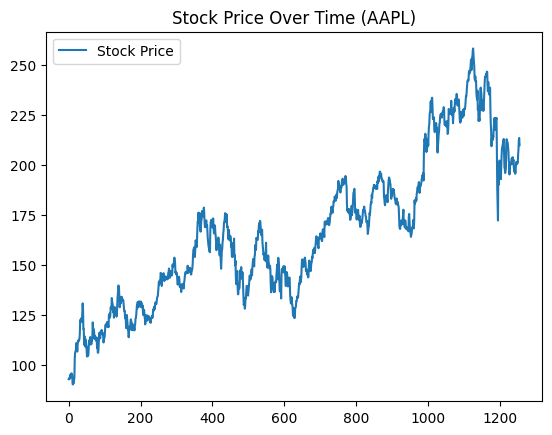

In [37]:
plt.plot(df['Close'], label='Stock Price')
plt.title("Stock Price Over Time (AAPL)")
plt.legend()
plt.show()


In [38]:
# Decision Logic Based on Net Worth Change
initial_balance = 1000
profit_margin = env.net_worth - initial_balance

print("\n💬 Investment Recommendation:")

if profit_margin > 50:
    print("✅ RECOMMENDATION: SPEND / INVEST")
    print(f"Reason: Agent generated a profit of ${profit_margin:.2f} over initial balance.")
elif profit_margin < -50:
    print("❌ RECOMMENDATION: DO NOT SPEND / INVEST")
    print(f"Reason: Agent incurred a loss of ${-profit_margin:.2f}.")
else:
    print("⚠️ RECOMMENDATION: HOLD / MONITOR")
    print(f"Reason: Agent's performance is neutral (${profit_margin:.2f}). Further training or data may help.")



💬 Investment Recommendation:
✅ RECOMMENDATION: SPEND / INVEST
Reason: Agent generated a profit of $532.89 over initial balance.
